# WHVI regression on a toy example

This notebook illustrates the use of WHVI through a univariate regression problem. The goal is to approximately match the performance of the method to a similar example from the paper (see section 3.1).

In [1]:
# Reproducibility
import numpy as np
import torch

np.random.seed(0)
torch.manual_seed(0);

## Creating the synthetic dataset

We first define our data generating process which we then sample from to create the synthetic dataset.
We know that $y = f(x) + \epsilon$ where $\epsilon \sim \mathrm{N}(0, \exp(-3))$, but the authors do not explicitly say what function $f$ is.
For this reason, we define a polynomial that is similar to it and see if we observe a similar pattern.
The polynomial coefficients are chosen based on observed extrema in the plot.

In [2]:
from torch.utils.data import Dataset, DataLoader

xs_poly = [-2.0, -1.5, -0.8, 0.0, 0.5, 1.4, 2.0, 2.7, 3.0]
ys_poly = [1.2, 1.5, 2.0, 0.5, -0.5, 1.2, 0.0, 1.0, 1.3]
vmat = np.vander(xs_poly, len(xs_poly))
coef = np.linalg.solve(vmat, ys_poly)
def f(x): return np.polyval(coef, x)

n = 128
x = np.random.rand(n) * 3 - 1
x = x[np.where((x < 0.6) | (x > 1.4))]
y = f(x) + np.random.randn(len(x)) * np.sqrt(np.exp(-3))
x = x.reshape(-1, 1).astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)

class ToyDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = ToyDataset(torch.tensor(x), torch.tensor(y))
data_loader = DataLoader(dataset, batch_size=len(x))

We wish to approximate the function below, as well as the measurement noise, i.e. the variance $\sigma^2 = \exp(-3)$.

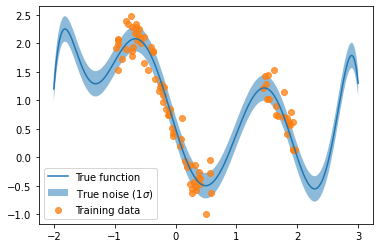

In [3]:
import matplotlib.pyplot as plt

x_tmp = np.linspace(-2, 3, 1000)
plt.plot(x_tmp, f(x_tmp), label='True function')
plt.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True noise (1$\sigma$)')
plt.scatter(x, y, alpha=0.75, label='Training data')
plt.legend()
plt.show()

## Creating a baseline non-Bayesian model

To see what we can expect from the model, we first check a non-Bayesian variant with the same architecture. The only difference is that this non-Bayesian version uses regular linear layers instead of WHVI linear layers. We expect that this model will be able to approximate the function quite closely.

In [4]:
import torch.optim as optim
import torch.nn as nn

from activations import Cosine

non_bayesian_model = nn.Sequential(
    nn.Linear(1, 128, bias=False),
    Cosine(),
    nn.Linear(128, 128, bias=False),
    Cosine(),
    nn.Linear(128, 1, bias=False)
)

gamma = 0.0005
p = 0.3
optimizer = optim.Adam(non_bayesian_model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t)**(-p))

In [5]:
import torch.nn.functional as F

for epoch in range(500):
    for batch_index, (data_x, data_y) in enumerate(data_loader):
        # reg_loss = 0.01 * sum((p ** 2).sum() for p in non_bayesian_model.parameters())
        loss = F.mse_loss(non_bayesian_model(data_x), data_y)# + reg_loss
        loss.backward()
        optimizer.step()
        non_bayesian_model.zero_grad(set_to_none=True)

Interestingly, the plot below indicates a poor fit to the data. This suggests that the Bayesian version of this model will not be good, because it will be even more difficult to fit it using ELBO as an approximation to the unknown criterion function. This does indeed turn out to be the case.

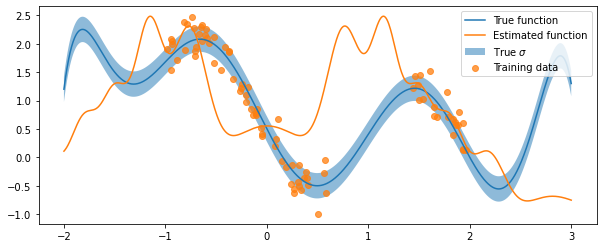

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))

x_test = torch.tensor(np.linspace(-2, 3, 1000).reshape(-1, 1).astype(np.float32))
y_test = torch.tensor(f(np.linspace(-2, 3, 1000)).reshape(-1, 1).astype(np.float32))
y_pred = non_bayesian_model(x_test).detach().numpy().ravel()
x_test = x_test.detach().numpy().ravel()

x_tmp = np.linspace(-2, 3, 1000)
plt.plot(x_tmp, f(x_tmp), label='True function')
plt.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True $\sigma$')
plt.plot(x_test, y_pred, label='Estimated function')
plt.scatter(x, y, alpha=0.75, label='Training data')
plt.legend(loc='upper right')
plt.show()

In [7]:
non_bayesian_model = nn.Sequential(
    nn.Linear(1, 128, bias=False),
    nn.Sigmoid(),
    nn.Linear(128, 128, bias=False),
    nn.Sigmoid(),
    nn.Linear(128, 1, bias=True)
)

gamma = 0.0005
p = 0.3
optimizer = optim.Adam(non_bayesian_model.parameters(), lr=1e-3, weight_decay=0.001)  # Weight decay causes L2 regularization
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t)**(-p))

for epoch in range(500):
    for batch_index, (data_x, data_y) in enumerate(data_loader):
        loss = F.mse_loss(non_bayesian_model(data_x), data_y)
        loss.backward()
        optimizer.step()
        non_bayesian_model.zero_grad(set_to_none=True)

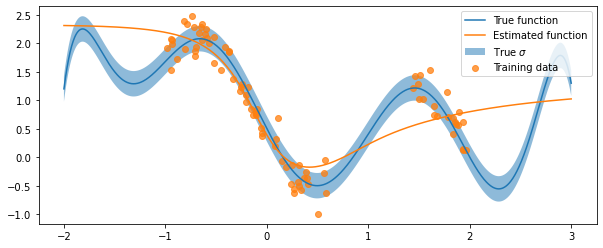

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))

x_test = torch.tensor(np.linspace(-2, 3, 1000).reshape(-1, 1).astype(np.float32))
y_test = torch.tensor(f(np.linspace(-2, 3, 1000)).reshape(-1, 1).astype(np.float32))
y_pred = non_bayesian_model(x_test).detach().numpy().ravel()
x_test = x_test.detach().numpy().ravel()

x_tmp = np.linspace(-2, 3, 1000)
plt.plot(x_tmp, f(x_tmp), label='True function')
plt.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True $\sigma$')
plt.plot(x_test, y_pred, label='Estimated function')
plt.scatter(x, y, alpha=0.75, label='Training data')
plt.legend(loc='upper right')
plt.show()

## Creating the WHVI model

In [9]:
from networks import WHVIRegression
from layers import WHVILinear

device = torch.device("cpu")

model = WHVIRegression([
    WHVILinear(1, 128, device=device, bias=False),
    nn.Sigmoid(),
    WHVILinear(128, 128, device=device, bias=False),
    nn.Sigmoid(),
    WHVILinear(128, 1, device=device, bias=True)
])

gamma = 0.0005
p = 0.3
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t)**(-p))

In [ ]:
model.train_model(data_loader, optimizer, epochs1=500, epochs2=50000)

[Opt. var.] KL = 885.63, MNLL = 115.57:   1%|          | 424/50000 [00:02<05:00, 165.05it/s]        

In [ ]:
x_test = torch.tensor(np.linspace(-2, 3, 1000).reshape(-1, 1).astype(np.float32))
y_test = torch.tensor(f(np.linspace(-2, 3, 1000)).reshape(-1, 1).astype(np.float32))
y_pred = model(x_test)

y_pred_mu = y_pred.mean(dim=2).detach().numpy().ravel()
y_pred_sd = y_pred.std(dim=2).detach().numpy().ravel()
x_test = x_test.detach().numpy().ravel()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

x_tmp = np.linspace(-2, 3, 1000)
plt.plot(x_tmp, f(x_tmp), label='True function')
plt.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True $\sigma$')
plt.plot(x_test, y_pred_mu, label='Estimated function')
plt.fill_between(x_test, y_pred_mu - y_pred_sd, y_pred_mu + y_pred_sd, label='Estimated $\sigma$');
plt.scatter(x, y, alpha=0.75, label='Training data')
plt.legend(loc='upper right')
plt.show()